In [31]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter



In [32]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
params_to_plot = [
    [False, False, 0, 0.0], #No balancing, without continuous
    [True, False, 0, 0.0], #No balancing with continuous
    [False, True, 0, 0.0], #balancing , without continuous
    [True, True, 0, 0.0], #balancing with continuous
    [False, True, 2000, 0.0], #2,000 extra , without continuous
    [True, True, 2000, 0.0], #2,000 extra with continuous
    [False, True, 2000, 0.8], #2,000 extra, with 80% reduction, without continuous
    [True, True, 2000, 0.8], #2,000 extra, with 80% reduction, with continuous
]
headers = ["continuous_augmentation", "augment_data", "extra_to_majority", "reduce_malignant_rate"]
df_runs = pd.DataFrame(params_to_plot, columns=headers)
## Place your run in params_to_plot, and then set my_run to the index
my_run = 1
my_row = df_runs.iloc[my_run]

In [34]:
num_epochs = 24
#agument_data means to add data ahead of time.  This should be off
# if you don't even want to balance the dataset
augment_data = my_row["augment_data"]
#In contrast to the above, augment_model means you want the
# augmentation layers added to the model itself
augment_model = False
#extra_to_majority = 0
extra_to_majority = my_row["extra_to_majority"]
#skip training should only be used if we have already ran this training run
# and just need to load the weights
skip_training=True
## Should there be continuous augmentation during training or not
continuous_augmentation = my_row["continuous_augmentation"]#False
fake_data = 0
top_dropout_rate = 0.2
artificially_reduce_malignant_rate = my_row["reduce_malignant_rate"]
#artificially_reduce_malignant_rate = 0.0
#if continuous_augmentation:
#  out_folder='b_aug_data_'+str(augment_data)+'_aug_model_'+str(augment_model)+'_extra_'+str(extra_to_majority)+'_malreduction_'+str(artificially_reduce_malignant_rate)
#else:
out_folder='b_aug_data_'+str(augment_data)+'_continuous_'+str(continuous_augmentation)+'_extra_'+str(extra_to_majority)+'_malreduction_'+str(artificially_reduce_malignant_rate)

output_directory = './drive/MyDrive/ML/BreastCancerProject/report/'+out_folder+'/'
os.makedirs(output_directory, exist_ok=True)

class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2

undersample_test = False

In [35]:
from matplotlib.layout_engine import TightLayoutEngine
from sklearn.metrics import confusion_matrix, classification_report

def compute_confusion_matrix_and_report(model, gen, title, image_file_name=None, text_file_name=None):
  print("Is gen shuffling = "+str(gen.shuffle))
  #gen.shuffle=False
  #print("Is gen shuffling = "+str(gen.shuffle))
  #unsorted_class_labels = {value: key for key, value in gen.class_indices.items()}
  #class_labels = {k: v for k, v in sorted(unsorted_class_labels.items(), key=lambda item: item[0])}
  #mbrewer extract this the correct way
  class_labels = ["benign", "malignant", "normal"]
  # Assuming 'gen' is a generator yielding (X, y) pairs
  # Replace this with the actual method you use to obtain predictions from your model

  y_pred = model.predict_generator(gen)

  # Assuming 'gen.classes' contains the true labels
  class_labels2 = gen.class_indices
  print("Class Labels:", class_labels2)
  y_true = gen.classes
  print(y_true)
  # Convert predicted probabilities to class labels
  y_pred_classes = np.argmax(y_pred, axis=1)
  print(y_pred_classes)
  # Compute the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred_classes)
  print(conf_matrix)

  # Print the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  if image_file_name:
    plt.savefig(output_directory+image_file_name)
  plt.show()

  # Print a classification report
  report = classification_report(y_true, y_pred_classes, target_names=class_labels)
  print("\nClassification Report:")
  print(report)
  if text_file_name:
    output_file_path = f"{output_directory}/{text_file_name}"
    # Writing the metrics to the text file
    with open(output_file_path, 'w') as f:
      # Writing metric names to the file
      f.write("Confusion Report:\n")
      f.write(str(conf_matrix))
      f.write("\nClassification Report: \n")
      f.write("Y (vertical) axis is the true label.  X (horizonatal) axis it the predicted label.\n")
      f.write(str(class_labels))
      f.write("\n")
      f.write(str(report))





# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, confidences=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    title="True: "+str(labels[i])
    if predictions:
      title += "\nPredicted: "+str(predictions[i])
    if confidences:
      title += "\nConfidence: "+str(confidences[i])

    plt.title(title)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  predictions = []
  ground_truth_labels = []
  # plot a single image
  outer=0
  for x,y in data_gen:
    print("Plotting x which length "+str(len(x)))
    for i in range(len(x)):
      outer+=1
      image = x[i]  # Get the ith image from the batch
      label_confidence=np.max(y[i])
      label_index = np.argmax(y[i])  # Get the index of the predicted class
      predictions.append(model.predict(tf.expand_dims(image, axis=0))[0])
      ground_truth_labels.append(class_labels[label_index])
      if( outer < 3):
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {class_labels[label_index]}\nConf: "+str(label_confidence))
        plt.grid(False)
        plt.show()
        # Check if the generator is exhausted
    break




  sample_size = min(num_images_to_display, len(predictions))
  sample_indices = random.sample(range(len(predictions)), sample_size)
  predict_confidence = [i for i in np.max(predictions, axis=1)]
  int_based = np.argmax(predictions, axis=1)
  int_based_list = list(int_based)
  predicted_labels = [class_labels[i] for i in int_based_list ]
  #Select a subset of test images and labels to display

  image_file_names = data_gen.filenames

  # Display the images and their labels/predictions
  i_to_plot, g_to_plot, p_to_plot, c_to_plot = [],[],[],[]
  for i, idx in enumerate(sample_indices):
    i_to_plot.append(image_file_names[idx])
    g_to_plot.append(ground_truth_labels[idx])
    p_to_plot.append( predicted_labels[idx])
    c_to_plot.append(predict_confidence[idx])
  display_images_in_grid(
      i_to_plot,
      g_to_plot,
      p_to_plot,
      c_to_plot)
  # Calculate accuracy
  #print('truth')
  #print(ground_truth_labels)
  #print('pred')
  #print(predicted_labels)
  accuracy = accuracy_score(ground_truth_labels, predicted_labels)
  print("Accuracy: {:.2%}".format(accuracy))
  ret={}
  ret['accuracy']=accuracy
  ret['groundtruth']=ground_truth_labels
  ret['filenames']=image_file_names
  ret['predictions']=predicted_labels
  return ret
  #f1 = f1_score(ground_truth_labels, predicted_labels)
  #print("F1: {:.2%}".format(accuracy))
  #ret['f1']=f1
  #precision = precision_score(ground_truth_labels, predicted_labels)
  #print("Precision: {:.2%}".format(precision))
  #ret['precision']=precision
  #recall = recall_score(ground_truth_labels, predicted_labels)
  #print("Recall: {:.2%}".format(recall))
  #ret['recall']=recall

def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()



def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Sort unique values alphabetically
  unique_values = sorted(df[xname].unique())

  # Create the count plot with sorted values
  sns.countplot(data=df, x=xname, order=unique_values)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()
  print("In total, the count of samples is "+str(len(df)))


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

class GeneratorType(Enum):
  TRAIN=1
  TEST=2
  INFERENCE=3

def create_generator(given_df, image_size, batch_size, augment=False,
                     gen_type=GeneratorType.TRAIN, rescale=1.):#rescale=1./255):
  # Create an ImageDataGenerator for reading and preprocessing the images
  # Normalize the intensitities to [0,1]
  # rescale = 1./255
  #color_mode = 'grayscale'
  if augment:
    print("Augmenting data")
  else:
    print("NOT augmenting data")
  color_mode='rgb'
  image_generator=None
  if gen_type is GeneratorType.INFERENCE:
    print("Creating Inference")
    image_generator = ImageDataGenerator(rescale=rescale)
    return [image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False,
      seed=42,
      color_mode=color_mode), image_generator]
  if gen_type is GeneratorType.TRAIN:
    print("Creating Train")
  elif gen_type is GeneratorType.TEST:
    print("Creating Test")
    image_generator = ImageDataGenerator(rescale=rescale)

  else:
    print("Unexpected value for gen_type="+str(gen_type))
    exit()
  if augment:

    image_generator = ImageDataGenerator(rescale=rescale,
                                         zoom_range=.2,
                                         horizontal_flip=True,
                                         rotation_range=40,
                                         width_shift_range=0.05,
                                         height_shift_range=.05,
                                          brightness_range=[0.9, 1.1]
                                         )
    print("Indeed generatoring with augmentation")
    return [image_generator.flow_from_dataframe(
        given_df,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        #zoom_range=.4,
        #horizontal_flip=True,
        #rotation_range=40,
        #width_shift_range=.3,
        #height_shift_range=.3,
        #fill_mode='nearest',
        color_mode=color_mode), image_generator]

  print("NOT generatoring with augmentation")
  image_generator = ImageDataGenerator(rescale=rescale)
  return [image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      seed=42,
      color_mode=color_mode), image_generator]

  import random

def undersample_list_pair(vals, labels):
  # Count the occurrences of each label in labels
  label_counts = Counter(labels)
  # Find the minimum count among label occurrences
  min_count = min(label_counts.values())
  # Undersample A and B to the minimum count for each label
  vals_undersampled = []
  labels_undersampled = []

  for label in label_counts:
    # Get the indices of elements in labels with the current label
    indices = [i for i, item in enumerate(labels) if item == label]

    # Randomly select 'min_count' indices for undersampling
    undersampled_indices = random.sample(indices, min_count)

    # Add the corresponding elements to A_prime and B_prime
    vals_undersampled.extend([vals[i] for i in undersampled_indices])
    labels_undersampled.extend([labels[i] for i in undersampled_indices])
  return [vals_undersampled, labels_undersampled]



In [36]:
# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator_unfiltered = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator_unfiltered.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=True,  # set this to False if you want to preserve the order
    seed=54
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 780 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [37]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
image_paths, labels = filter_mask_images(unfiltered_data_generator.filepaths, [class_labels[i] for i in unfiltered_data_generator.classes])
print("Image path size = "+str(len(image_paths)))

Image path size = 780


Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 624 validated image filenames belonging to 3 classes.
NOT augmenting data
Creating Inference
Found 624 validated image filenames belonging to 3 classes.
NOT augmenting data
Creating Test
NOT generatoring with augmentation
Found 156 validated image filenames belonging to 3 classes.
NOT augmenting data
Creating Inference
Found 156 validated image filenames belonging to 3 classes.


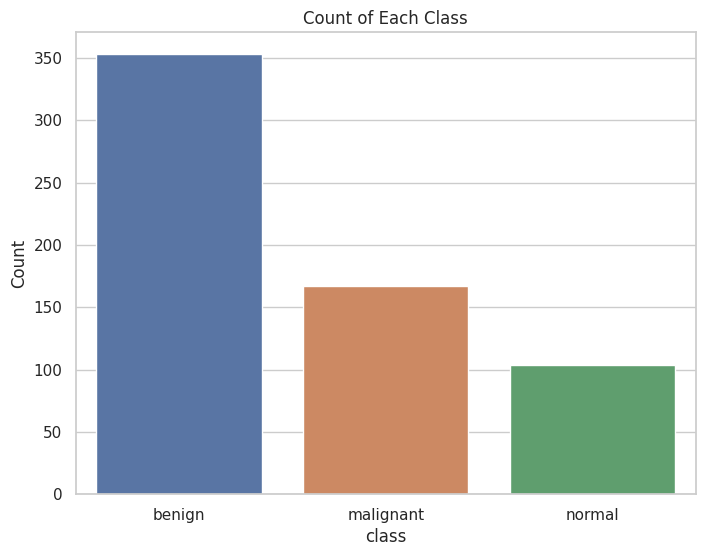

In total, the count of samples is 624
                                                                                        filename  \
0        ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (22).png   
1  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (91).png   
2       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (219).png   
3       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (419).png   
4       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (149).png   

       class  
0     normal  
1  malignant  
2     benign  
3     benign  
4     benign  


In [38]:

train_image_paths, test_image_paths_full, train_labels, test_labels_full = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
if undersample_test:
  test_image_paths, test_labels = undersample_list_pair(test_image_paths_full, test_labels_full)
else:
  test_image_paths=test_image_paths_full
  test_labels=test_labels_full
# Create separate data generators for training and testing
# Augmentation now doesn't matter for these generators
# becase we just pull the filenames and create new generators?
train_data_generator, train_image_generator = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    augment=True,
    gen_type=GeneratorType.TRAIN)
train_data_generator_inference, train_image_generator_inference = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    gen_type=GeneratorType.INFERENCE)


test_data_generator, test_image_generator = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    #augment=True,
    gen_type=GeneratorType.TEST)
test_data_generator_inference, test_image_generator_inference = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    gen_type=GeneratorType.INFERENCE)

# Convert the class indices to class labels
class_labels = list(train_data_generator.class_indices.keys())

# Create a DataFrame with the train image file paths and labels
df = pd.DataFrame({
    'filename': train_data_generator.filepaths,
    'class': [class_labels[i] for i in train_data_generator.classes]
})



pd.set_option('display.max_colwidth', None)
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

DF Malignant length is 167
DF Malignant final is 167
Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 104 validated image filenames belonging to 1 classes.
Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 167 validated image filenames belonging to 1 classes.
Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 353 validated image filenames belonging to 1 classes.


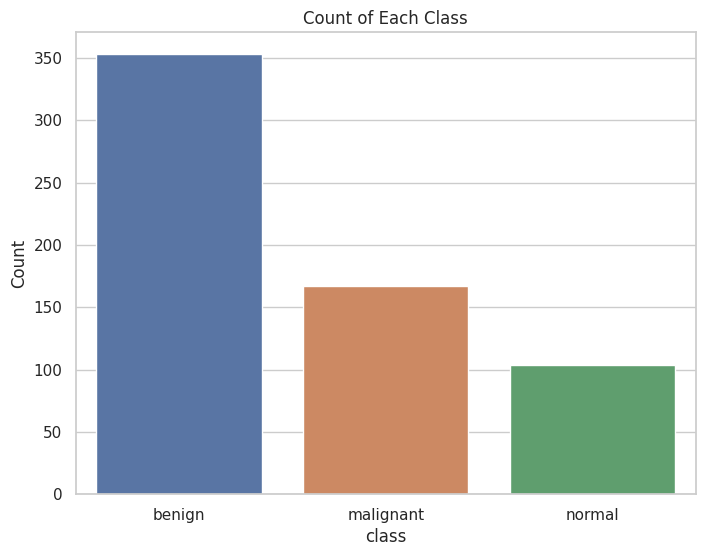

In total, the count of samples is 624
                                                                                   filename  \
0   ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (22).png   
19  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (59).png   
24  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (42).png   
41  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (35).png   
50  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (43).png   

     class  
0   normal  
19  normal  
24  normal  
41  normal  
50  normal  
Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 624 validated image filenames belonging to 3 classes.


In [39]:
# Create DataFrames for each class
df_normal = df[df['class'] == 'normal']
df_malignant = df[df['class'] == 'malignant']
print("DF Malignant length is "+str(len(df_malignant)))
if artificially_reduce_malignant_rate > 0:
  rows_to_keep = int(len(df_malignant) * (1 - artificially_reduce_malignant_rate))
  # Randomly sample rows to keep
  df_malignant = df_malignant.sample(n=rows_to_keep, random_state=42)  # Set a random seed for reproducibility

print("DF Malignant final is "+str(len(df_malignant)))

df_benign = df[df['class'] == 'benign']
# Calculate the number of samples in the majority class
majority_count = max(len(df_normal), len(df_malignant), len(df_benign)) + extra_to_majority

extra_benign = 0
extra_normal = 0
extra_malignant = 0

if augment_data:
  extra_benign = majority_count - len(df_benign)
  extra_normal = majority_count - len(df_normal)
  extra_malignant = majority_count - len(df_malignant)


# Oversample 'normal' class
normal_generator, normal_image_gen = create_generator(
    df_normal,
    image_size,
    extra_normal,
    True,
    GeneratorType.TRAIN
)

# Oversample 'malignant' class
malignant_generator, malignant_image_gen = create_generator(
    df_malignant,
    image_size,
    extra_malignant,
    True,
    GeneratorType.TRAIN
)

# Oversample 'benign' class
benign_generator, benign_image_gen = create_generator(
    df_benign,
    image_size,
    extra_benign,
    True,
    GeneratorType.TRAIN
)
if augment_data:
  aa=df_normal.sample(extra_normal, replace=True)
  bb=df_malignant.sample(extra_malignant, replace=True)
  cc=df_benign.sample(extra_benign, replace=True)
  print(len(aa))
  print(len(bb))
  print(len(cc))

  # Concatenate the oversampled dataframes
  augmented_data = pd.concat([df_normal, df_malignant, df_benign,
                              aa,bb,cc])
else:
  augmented_data = pd.concat([df_normal, df_malignant, df_benign])

# Now 'augmented_data' contains your balanced dataset with augmented data
df=augmented_data
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())
train_data_generator_aug, train_image_generator_aug = create_generator(
    df,
    image_size,
    batch_size,
    augment=continuous_augmentation,
    gen_type=GeneratorType.TRAIN)


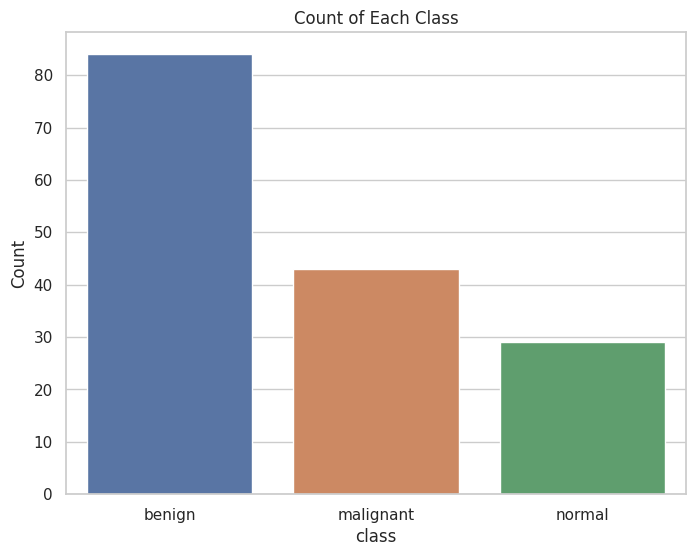

In total, the count of samples is 156
                                                                                         filename  \
0   ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (52).png   
1   ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (45).png   
2  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (195).png   
3   ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (97).png   
4  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (144).png   

       class  
0  malignant  
1  malignant  
2  malignant  
3  malignant  
4  malignant  


In [40]:

class_labels_test = list(test_data_generator.class_indices.keys())
# Create a DataFrame with the train image file paths and labels
df_test = pd.DataFrame({
    'filename': test_data_generator.filepaths,
    'class': [class_labels_test[i] for i in test_data_generator.classes]
})

pd.set_option('display.max_colwidth', None)
plot_class_counts(df_test, "class")
# Display the first few rows of the DataFrame
print(df_test.head())

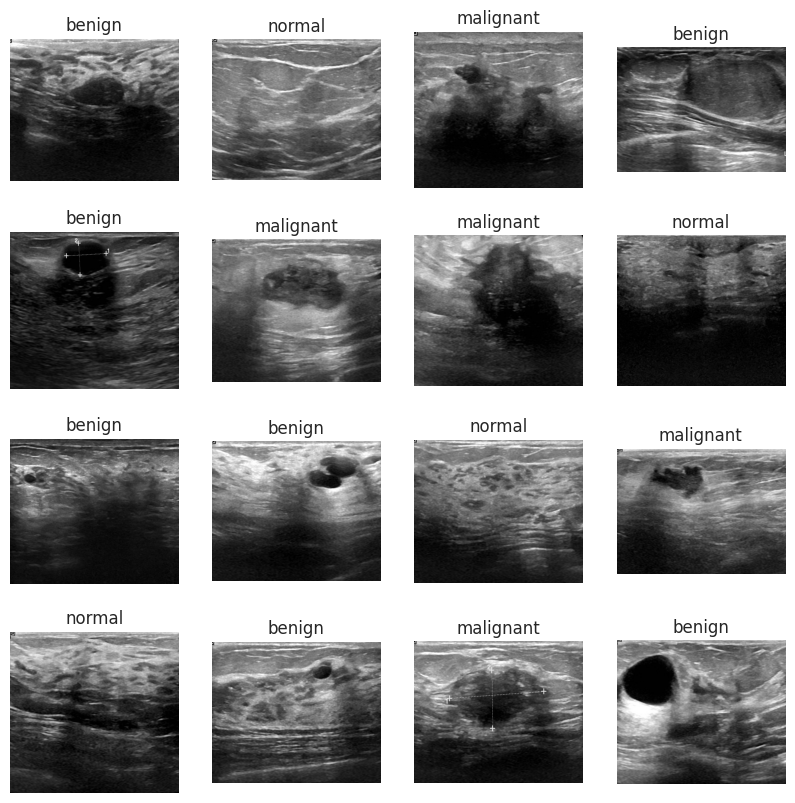

In [41]:


plot_sample_from_filenames(df)


Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 1 validated image filenames belonging to 1 classes.
NOT augmenting data
Creating Train
NOT generatoring with augmentation
Found 1 validated image filenames belonging to 1 classes.
./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (203).png


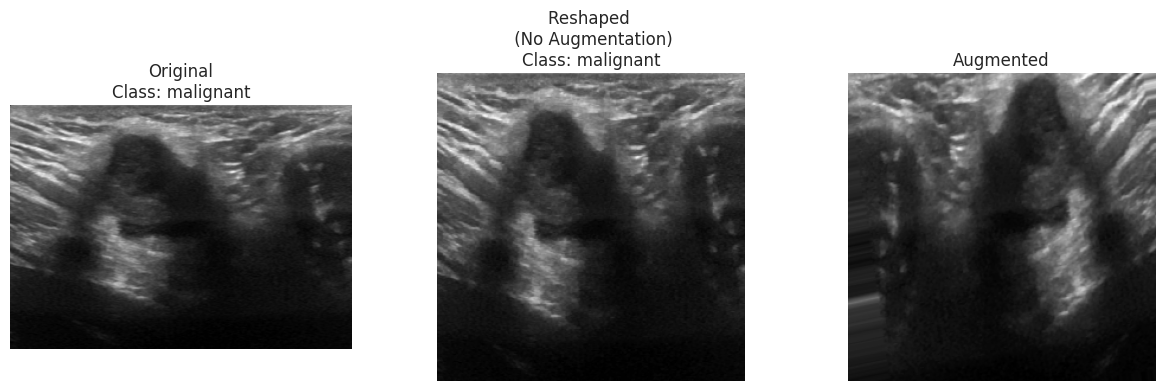

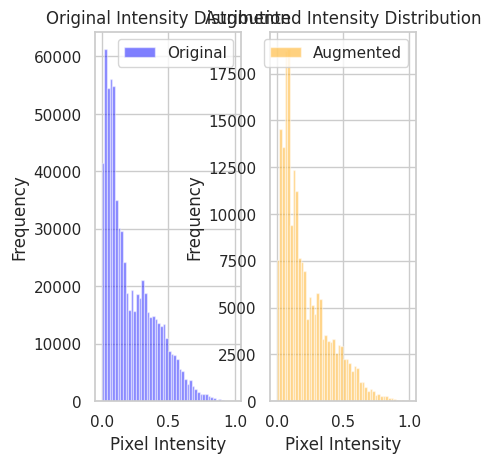

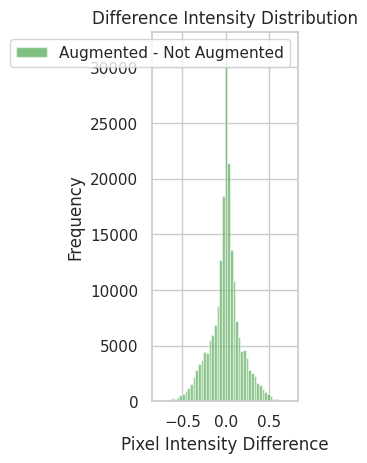

Augmenting data
Creating Train
Indeed generatoring with augmentation
Found 1 validated image filenames belonging to 1 classes.
NOT augmenting data
Creating Train
NOT generatoring with augmentation
Found 1 validated image filenames belonging to 1 classes.
./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (113).png


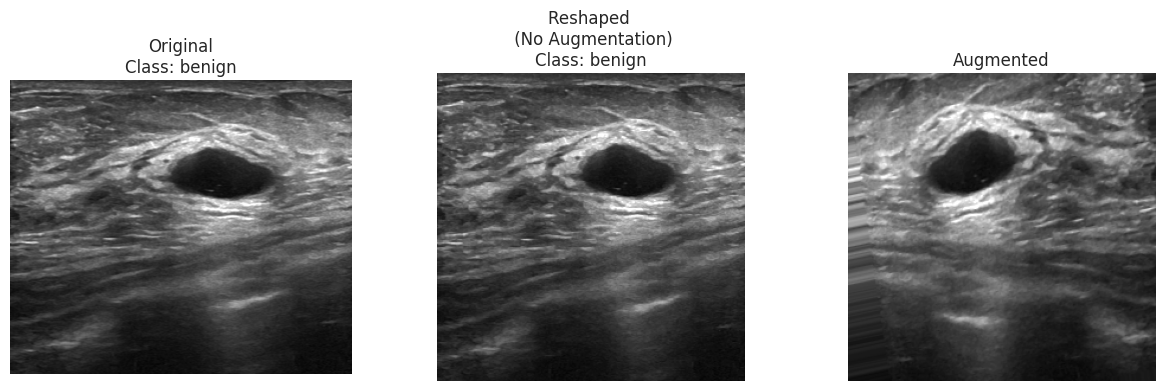

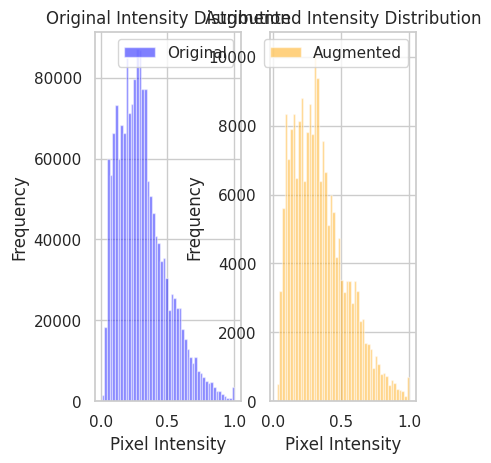

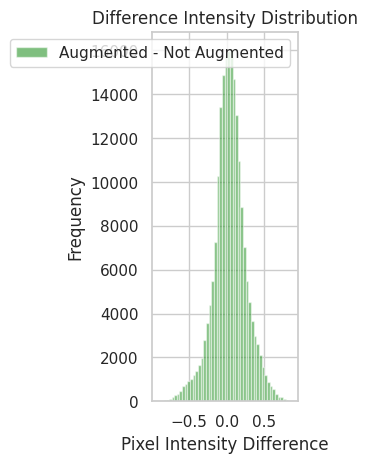

In [42]:
## TEMPORARY TEST
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Assuming you have a function create_generator similar to the one in your question

# Function to create a DataFrame with a single row sampled from the original DataFrame
def create_single_row_df(original_df, seed_factor):
    sample_row = original_df.sample(1, random_state=42*(9+seed_factor)%423)
    return sample_row

# Function to plot images
def plot_images(original_file, image_noaug, augmented_image, original_label):
    plt.figure(figsize=(15, 4))

    # Plot original image
    plt.subplot(1, 3, 1)

    imgo = plt.imread(original_file)
    plt.imshow(imgo)
    plt.title(f"Original\nClass: {original_label}")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(1, 3, 2)
    plt.imshow(image_noaug)
    plt.title(f"Reshaped \n (No Augmentation)\nClass: {original_label}")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(1, 3, 3)
    plt.imshow(augmented_image)
    plt.title("Augmented")
    plt.axis('off')

    plt.show()
    # Plot intensity distribution
    plt.subplot(1, 3, 1)
    plt.hist(imgo.flatten(), bins=50, alpha=0.5, label='Original', color='blue')
    plt.title('Original Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(augmented_image.flatten(), bins=50, alpha=0.5, label='Augmented', color='orange')
    plt.title('Augmented Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    # Plot histogram of augmented_image.flatten() - original_image_array.flatten()
    plt.subplot(1, 3, 3)
    difference_histogram = augmented_image.flatten() - image_noaug.flatten()
    plt.hist(difference_histogram, bins=50, alpha=0.5, label='Augmented - Not Augmented', color='green')
    plt.title('Difference Intensity Distribution')
    plt.xlabel('Pixel Intensity Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Set the sample flag to control whether to execute the block
sample = True

num_samples = 2
for i in range(num_samples):
    # Sample a single row from the original DataFrame
    single_row_df = create_single_row_df(df, i+1)

    # Use create_generator to create a generator and an iterator
    iter, generator = create_generator(
        single_row_df,
        image_size,
        batch_size=1,  # Set batch_size to 1 to get a single image
        augment=True,
        gen_type=GeneratorType.TRAIN)
    iternoaug, generatornoaug = create_generator(
        single_row_df,
        image_size,
        batch_size=1,  # Set batch_size to 1 to get a single image
        augment=False,
        gen_type=GeneratorType.TRAIN)
    # Get a batch of images from the iterator
    batch = next(iter)
    batchnoaug = next(iternoaug)

    # Extract original image and label
    original_image_path = single_row_df['filename'].values[0]
    print(original_image_path)

    original_numeric_label = batch[1][0]  # Assuming labels are in the first element of the batch
    # Get the class indices mapping from the ImageDataGenerator
    class_indices = iter.class_indices

    # Reverse the class indices mapping to get a label-to-numeric mapping
    label_to_numeric = {v: k for k, v in class_indices.items()}

    # Convert the numeric label to a string label
    original_label = label_to_numeric[np.argmax(original_numeric_label)]
    # Extract augmented image
    augmented_image = batch[0][0] / 255.
    image_noaug = batchnoaug[0][0] / 255.

    # Plot the images
    plot_images(original_image_path, image_noaug,augmented_image, original_label)



In [43]:
num_classes = 3
base_model = None

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size[0], image_size[1]),
  layers.Rescaling(1./255)
])

if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()

model = None
if augment_model:
  model = tf.keras.Sequential([
    resize_and_rescale,
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(top_dropout_rate, name="top_dropout"),
    layers.Dense(num_classes, activation='softmax')
  ])
else:
  model = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(top_dropout_rate, name="top_dropout"),
    layers.Dense(num_classes, activation='softmax')
  ])

# Specify the input shape for the first layer
model.build(input_shape=(batch_size, image_size[0], image_size[1], 3))


#model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




31936256/31936256 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 260, 260, 3)         0         
                                                                 
 efficientnet-b2 (Functiona  (None, 9, 9, 1408)        7768562   
 l)                                                              
                                                                 
 global_average_pooling2d (  (32, 1408)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (32, 1408)                5632      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (32, 1408)                0         
                                                      

In [44]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [45]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.0001 # mbrewer change back to .001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
best_model = output_directory+'best_model_2000_aug'+str(image_size[0])+'.h5'
model_checkpoint = ModelCheckpoint(best_model, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
if not skip_training:
  # Train your model and use the callbacks
  history = model.fit(
      train_data_generator_aug,
      epochs=num_epochs,
      validation_data=test_data_generator,
      callbacks=[model_checkpoint, early_stopping, lr_scheduler],
      verbose=1,  # Set verbose to 1 to display training progress,
  )
model.load_weights(best_model)


Epoch 1/24
221/221 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.7694
Epoch 1: val_loss improved from inf to 0.72217, saving model to ./drive/MyDrive/ML/BreastCancerProject/report/b_aug_data_True_continuous_True_extra_2000_malreduction_0.5/best_model_2000_aug260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 312s 1s/step - loss: 0.5864 - accuracy: 0.7694 - val_loss: 0.7222 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 2/24
221/221 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9340
Epoch 2: val_loss improved from 0.72217 to 0.51610, saving model to ./drive/MyDrive/ML/BreastCancerProject/report/b_aug_data_True_continuous_True_extra_2000_malreduction_0.5/best_model_2000_aug260.h5
221/221 [==============================] - 252s 1s/step - loss: 0.1826 - accuracy: 0.9340 - val_loss: 0.5161 - val_accuracy: 0.7885 - lr: 1.0000e-04
Epoch 3/24
221/221 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9701
Epoch 3: val_loss improved from 0.51610 to 0.37363, saving model to ./drive/MyDrive/ML/BreastCancerProject/report/b_aug_data_True_continuous_True_extra_2000_malreduction_0.5/best_model_2000_aug260.h5
221/221 [==============================] - 257s 1s/step - loss: 0.0949 - accuracy: 0.9701 - val_loss: 0.3736 -

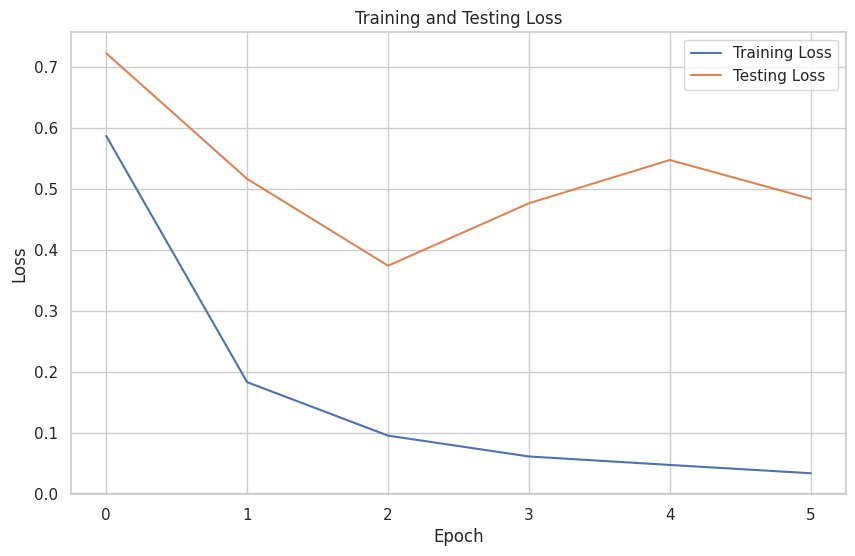

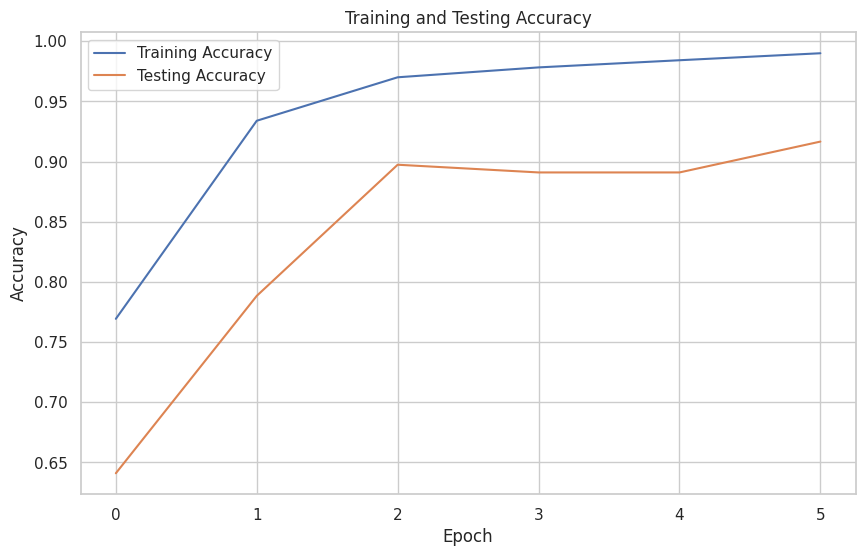

In [46]:
if not skip_training:
  # Assuming you've trained your model and have the `history` object
  # The `history` object typically contains 'loss' and 'val_loss' values

  # Plot training and testing loss
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Testing Loss')
  plt.title('Training and Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig(output_directory+'training_testing_loss_plot.png')
  plt.show()
  # Plot training and testing loss
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
  plt.title('Training and Testing Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.savefig(output_directory+'training_testing_accuracy_plot.png')
  plt.show()


In [ ]:


def eval_ds(gen, model, num_classes, name):
  print("Evaluating "+name)
  metrics = model.evaluate(gen)
  print(model.metrics_names)
  print(metrics)
  output_file_path = f"{output_directory}/metrics_{name}.txt"
  # Writing the metrics to the text file
  with open(output_file_path, 'w') as f:
    # Writing metric names to the file
    f.write("Metric Names: \n")
    f.write(str(model.metrics_names) + "\n\n")
    # Writing metric values to the file
    f.write("Metrics: \n")
    f.write(str(metrics) + "\n")

print("Test Inference ")
eval_ds(test_data_generator_inference, model,num_classes, "test inference")

print("Train Inference ")
eval_ds(train_data_generator_inference, model,num_classes, "train inference")


Test Inference 
Evaluating test inference
5/5 [==============================] - 2s 319ms/step - loss: 0.3736 - accuracy: 0.8974
['loss', 'accuracy']
[0.3736319839954376, 0.8974359035491943]
Train Inference 
Evaluating train inference
20/20 [==============================] - 8s 372ms/step - loss: 0.2169 - accuracy: 0.9407
['loss', 'accuracy']
[0.21692050993442535, 0.9407051205635071]


Is gen shuffling = False


<ipython-input-25-114c9c4660c5>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(gen)


Class Labels: {'benign': 0, 'malignant': 1, 'normal': 2}
[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 1 1 1 0 2 1 0 1 0 1 2 2 2 0 1 0 0 0 0 0 0 1 0 1 2 1 0 0 1 0 0 1 2 0 2
 0 1 1 1 2 0 2 0 2 1 0 0 2 1 2 0 2 0 0 0 1 2 1 0 0 2 0 0 1 1 0 1 1 0 2 0 0
 0 1 0 2 1 0 0 2 1 0 1 2 2 2 0 0 2 0 0 0 2 2 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1
 0 1 2 0 0 2 0 0 2 0 2 1 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 1 0 0 0 2 1 0 2 1 1
 0 0 0 0 0 0 0 0]
[[75  5  4]
 [ 5 37  1]
 [ 0  1 28]]


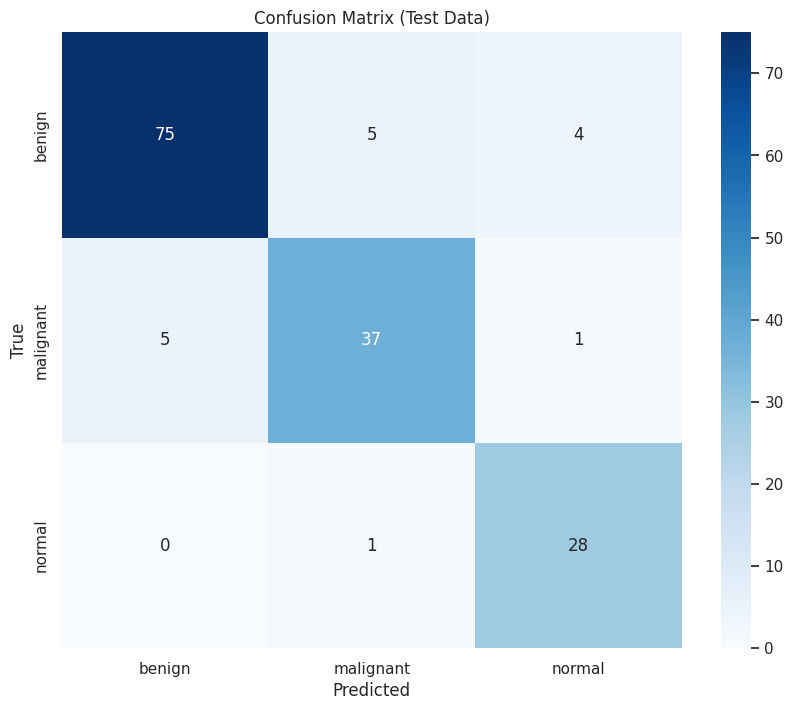


Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.89      0.91        84
   malignant       0.86      0.86      0.86        43
      normal       0.85      0.97      0.90        29

    accuracy                           0.90       156
   macro avg       0.88      0.91      0.89       156
weighted avg       0.90      0.90      0.90       156



In [ ]:
#results=predict_and_display_images_in_grid(model, test_data_generator)
#ground_truth_labels=results['groundtruth']
##predicted_labels=results['predictions']
#print(len(ground_truth_labels))
#print(len(predicted_labels))
compute_confusion_matrix_and_report(model, test_data_generator_inference,  "Confusion Matrix (Test Data)",
'test_data_confusion_plot.png', 'test_data_confusion_plot.txt')

Is gen shuffling = False


<ipython-input-25-114c9c4660c5>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(gen)


Class Labels: {'benign': 0, 'malignant': 1, 'normal': 2}
[2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 

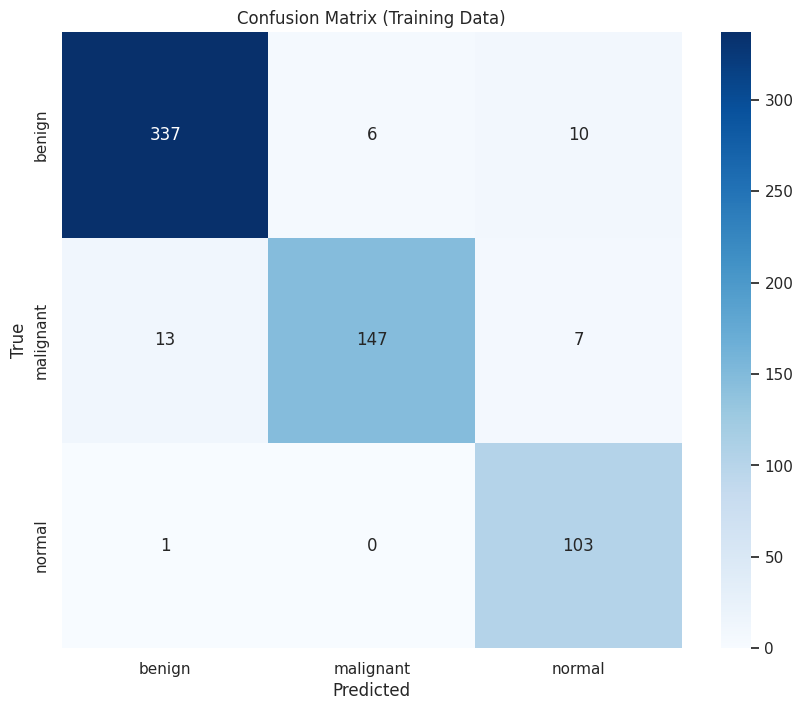


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.95      0.96       353
   malignant       0.96      0.88      0.92       167
      normal       0.86      0.99      0.92       104

    accuracy                           0.94       624
   macro avg       0.93      0.94      0.93       624
weighted avg       0.94      0.94      0.94       624



In [ ]:
#results_training=predict_and_display_images_in_grid(model, train_data_generator);
#ground_truth_labels_training=results_training['groundtruth']
#predicted_labels_training=results_training['predictions']

#print(len(ground_truth_labels_training))
#print(len(predicted_labels_training))

compute_confusion_matrix_and_report(model, train_data_generator_inference,  "Confusion Matrix (Training Data)")

In [ ]:

#(ground_truth_labels, predicted_labels, "Confusion Matrix (Test Data)")
#show_confusion_matrix(ground_truth_labels_training, predicted_labels_training, "Confusion Matrix (Training Data)")